# CLASSIFICATION DES IMAGES DE L'ATLAS DES PROTEINES HUMAINES

## But de la recherche : 

Cartographier toutes les protéines de toutes les cellules humaines. Pour ce faire il y a besoin de les localiser à l'aide de repères. Ces repères sont les organites de la cellule.











##Contexte :
Il existe 27 types d'organites cellulaires recensés dans l'ensemble des cellules humaines qu'on cherche à identifier pour pouvoir les prédire de façon automatique lors de futurs analyses de cellules aux microscopes.

Pour ce, il nous faut créer un modèle à partir d'une banque d'images cellulaire filtrés par 4 marqueurs:

Vert qui marque la protéine
bleu pour le noyau
rouge pour le RE
jaune pour les microtubule.

**N.B**: Chaque echantillon d'image dont on dispose est subdiVisé en 4 fichier, correspondant donc aux filtres vert, rouge, bleu, jaune.

##Éléments dont on dispose :

les données dont on dispose  :

- un fichier CSV appelé "train Csv" qui contient les noms de fichiers et les étiquettes pour l'ensemble d'entraînement.
- Un fichier CSV appelé "sample submission Csv" qui contient les noms de fichiers pour l'ensemble de tests et un guide pour construire une soumission valide.
- Un fichier ZIP appelé "train zip" qui contient toutes les images pour l'ensemble d'entraînement.
- Un fichier ZIP appelé "test.zip" qui contient toutes les images pour l'ensemble de test.

Les champs de données sont :
- "Id" qui est le nom de base du fichier pour chaque échantillon. Comme indiqué précédemment, tous les échantillons sont constitués de quatre fichiers - bleu, vert, rouge et jaune.
"Target" qui représente les étiquettes attribuées à chaque échantillon dans les données d'entraînement.


**Remarque importante : au vu de la surcharge des données, nous avons décidé de ne manipuler que le fichier "Train_csv", étant complet et remaniable à la fois pour l'entrainement, le test et la validation du model**

## Résumé de la méthode de construction de notre réseau de neurones :


### Voici les étapes que nous avons réalisées dans le notebook qui suit :

1 - chargement et visualisation des données  

2 - Construction d'un data frame "Images" avec les échantillons d'images dont les filtres ont été regroupés en une image

3 - Construction du Dataframe "target sample", avec un tableau de 
classification **binaire** des organites selon la liste des échantillons

4 - Entrainement des données avec 80% puis 50% de données d'entrainement

5 - Création d'un modèle CNN avec couches de convolution, GlobalAveragePooling et couches de densité.

6 - Compilation du modèl avec les fontions "Adam", "binary_crossentropy" et "binary_accuracy"

7 - Evaluation de l'efficacité modèles et visualisation du "loss" et "accuracy" sous format plot.

## Importation des données

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!echo '{"username":"marierogernoahnoah","key":"d4df2f4a49c1615bd4ead1be347dbd16"}'> ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c human-protein-atlas-image-classification

100% 17.5G/17.5G [02:13<00:00, 165MB/s]
100% 17.5G/17.5G [02:13<00:00, 140MB/s]


In [ ]:
!unzip human-protein-atlas-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/f5b629aa-bbbb-11e8-b2ba-ac1f6b6435d0_blue.png  
  inflating: train/f5b629aa-bbbb-11e8-b2ba-ac1f6b6435d0_green.png  
  inflating: train/f5b629aa-bbbb-11e8-b2ba-ac1f6b6435d0_red.png  
  inflating: train/f5b629aa-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png  
  inflating: train/f5b6f5c0-bbc4-11e8-b2bc-ac1f6b6435d0_blue.png  
  inflating: train/f5b6f5c0-bbc4-11e8-b2bc-ac1f6b6435d0_green.png  
  inflating: train/f5b6f5c0-bbc4-11e8-b2bc-ac1f6b6435d0_red.png  
  inflating: train/f5b6f5c0-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png  
  inflating: train/f5baae8e-bbc1-11e8-b2bb-ac1f6b6435d0_blue.png  
  inflating: train/f5baae8e-bbc1-11e8-b2bb-ac1f6b6435d0_green.png  
  inflating: train/f5baae8e-bbc1-11e8-b2bb-ac1f6b6435d0_red.png  
  inflating: train/f5baae8e-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png  
  inflating: train/f5c09c38-bbc4-11e8-b2bc-ac1f6b6435d0_blue.png  
  inflating: train/f5c09c38-bbc4-11e8-b2bc-ac1f6b6435d0_green.png  
  in

## Importation des librairies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pathlib as p
from PIL import Image
import seaborn as sns
from keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.callbacks import EarlyStopping

## Prétraitement des données

### Importation et Lecture des images

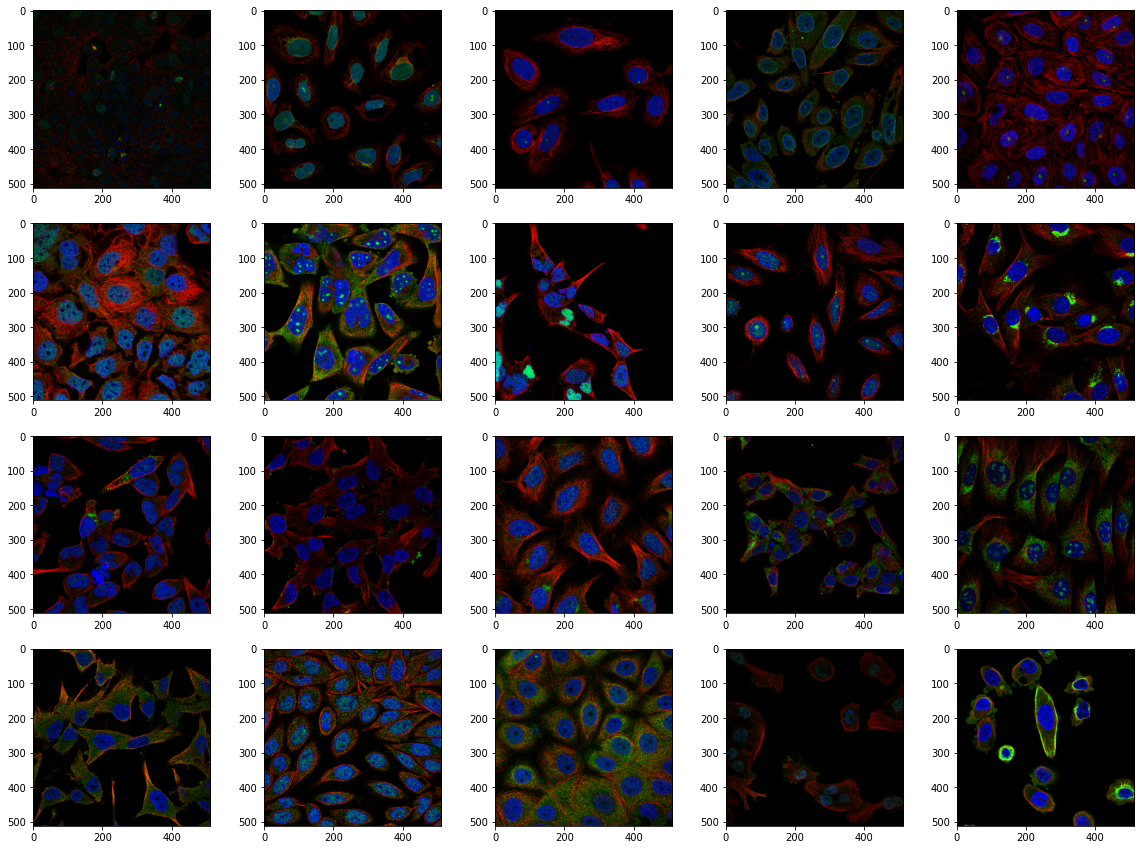

In [ ]:
#Téléchargement du dataset train.csv comme un  pandas dataframe
train_df = pd.read_csv("train.csv")

# le nombre d'images par ligne et colonne dans le  subplot
nrows = 4
ncols = 5

# Creation du subplot avec nrows and ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
axes = axes.ravel()  # Aplatissement  du tableau des axes

for index, row in train_df[:20].iterrows():
    # Recherche des valeurs de  l'Id et du Target value pour la colonne actuel
    Id = row['Id']
    target = row['Target']

    # Téléchargement des images des filtres red, green, yellow et blue 
    red_img = plt.imread(f"train/{Id}_red.png")
    green_img = plt.imread(f"train/{Id}_green.png")
    blue_img = plt.imread(f"train/{Id}_blue.png")
    yellow_img = plt.imread(f"train/{Id}_yellow.png")
    # Combinaison des images dans une seule image avec 3 canaux
    image = np.stack((red_img, green_img, blue_img), -1)

    # Ajout de l'image dans le subplot
    axes[index].imshow(image)
    #axes[index].set_title(f"Id: {Id} - Target: {target}")
    axes[index].axis('on')

plt.show()


### Redimensionnement des images et Normalisation des données




In [ ]:
# Taille de l'image redimensionnée
img_size = (32, 32)

# Charger les données de train.csv
data = pd.read_csv("train.csv")

# Création d'une fonction qui redimensionne les images
def reszie_and_scale_image(img, target_size):
    img = cv2.resize(img, target_size)
    img = img/255
    return img

# Création d'une fonction qui lit les images redimensionnées
def read_img(paths):
    red = cv2.imread(paths[0], 0)
    red = reszie_and_scale_image(red, img_size)
    blue = cv2.imread(paths[1], 0)
    blue = reszie_and_scale_image(blue, img_size)
    yellow = cv2.imread(paths[2])
    yellow = reszie_and_scale_image(yellow, img_size)
    green = cv2.imread(paths[3], 0)
    green = reszie_and_scale_image(green, img_size)
    return np.array([np.stack(
        (red, green, blue), -1
    ), yellow])

# liste pour stocker les images redimensionnées et normalisées
img_list = []

# Boucle sur les entrées pour redimensionner et normaliser les images pour chaque filtre
for i, (filename, label) in enumerate(data.values):
    paths = [
        "train/{}_red.png".format(str(filename)),
        "train/{}_blue.png".format(str(filename)),
        "train/{}_yellow.png".format(str(filename)),
        "train/{}_green.png".format(str(filename))
    ]
    img = read_img(paths)
    img_list.append(img)

# Convertir la liste en tableau numpy pour être lisible par Keras et TensorFlow
img_np_array = np.array(img_list)


In [ ]:
img_np_array.shape

(31072, 2, 32, 32, 3)

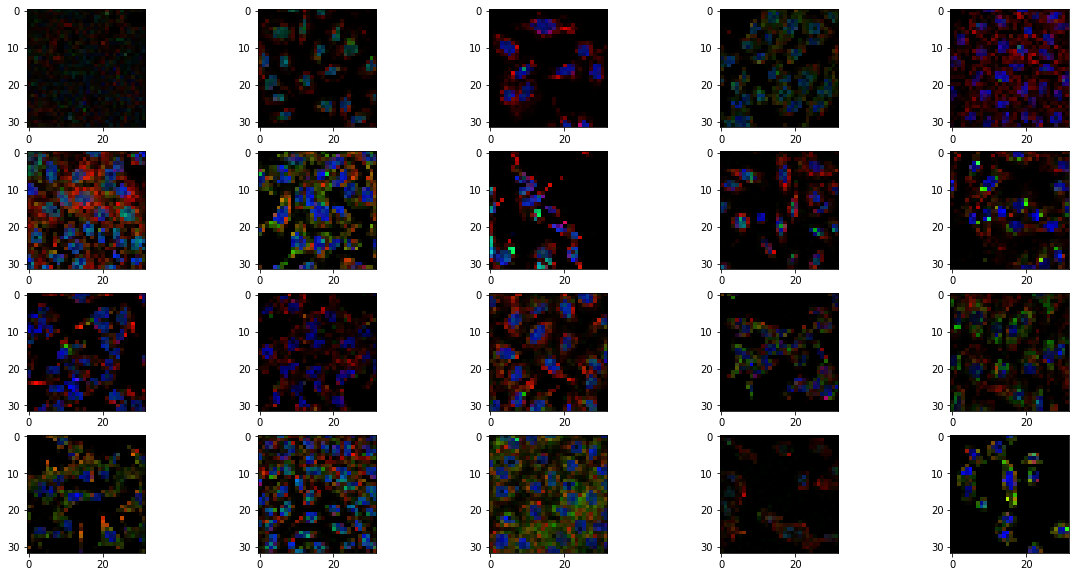

In [ ]:
# Afficher 20 images à partir du tableau numpy img_np_array
fig, axs = plt.subplots(4, 5, figsize=(20, 10))
axs = axs.ravel()

for i in range(20):
    axs[i].imshow(img_np_array[i][0])
    axs[i].axis('on')
plt.show()


### Présentation des étiquettes cibles

In [ ]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_data = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

In [ ]:
for key in label_names.keys():
    data[label_names[key]] = 0

In [ ]:
data = data.apply(fill_targets, axis=1)
data.head()

<ipython-input-11-ef61f1d3e627>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  row.Target = np.array(row.Target.split(" ")).astype(np.int)


,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


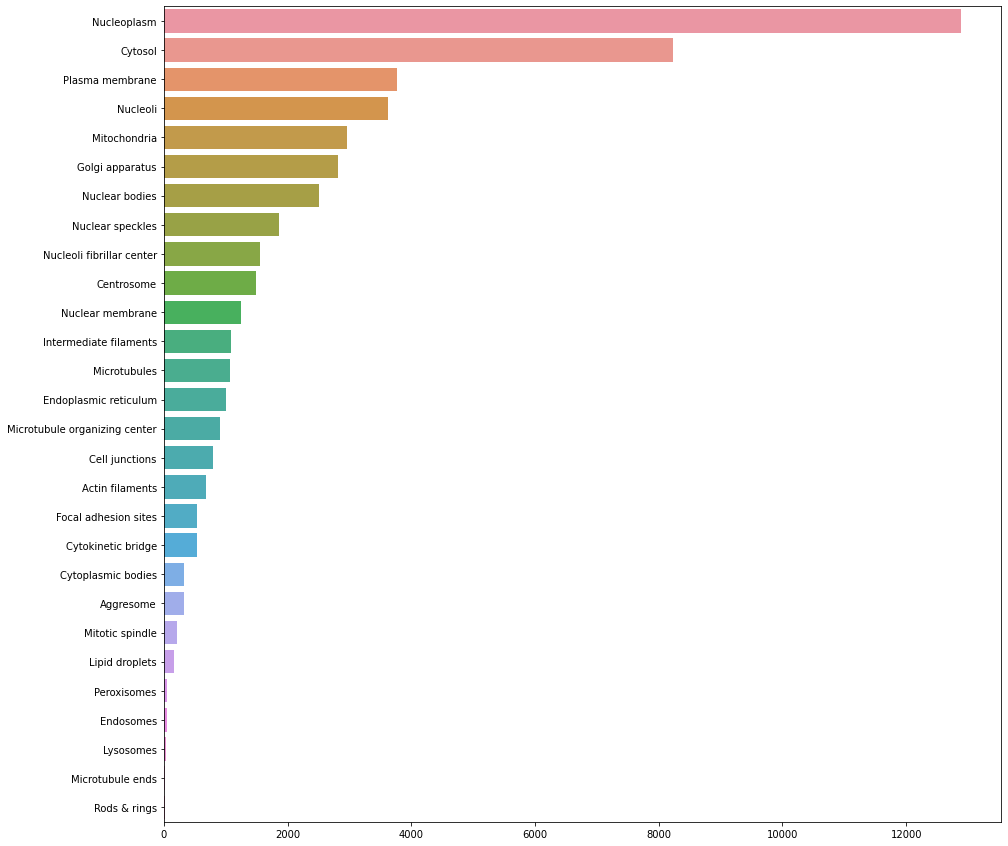

In [ ]:
target_counts = data.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

### Création du tableau numpy des étiquettes cibles

In [ ]:
# Initialisation du tableau numpy de zéros
target_sample = np.zeros((len(train_df), 28), dtype=int)

# Récupérer les étiquettes cibles de chaque entrée
targets = train_df['Target']

# Boucle pour itérer sur les entrées
for index, tar in enumerate(targets):
    # Séparer les étiquettes cibles en une liste d'entiers
    ids = tar.split()
    # Boucle pour itérer sur la liste d'entiers
    for id in ids:
        # Mettre à 1 la case correspondante dans le tableau cible_après
        target_sample[index, int(id)] = 1


In [ ]:
target_sample.shape

(31072, 28)

In [ ]:
target_sample[4]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
target_sample

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]])

# Implémentation du modèle de classification 

## Séparation des données en ensemble d'entraînement, test et validation

In [ ]:
from sklearn.model_selection import train_test_split

# Séparer les données en ensembles d'entraînement et de test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(img_np_array, target_sample, test_size=0.2, random_state=42)

# Séparer les données de test en ensembles de validation et de test finaux (50% / 50%)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [ ]:
X_train.shape, X_test.shape, X_val.shape

((24857, 2, 32, 32, 3), (3108, 2, 32, 32, 3), (3107, 2, 32, 32, 3))

In [ ]:
y_train.shape, y_test.shape,y_val.shape

((24857, 28), (3108, 28), (3107, 28))

In [ ]:
#from sklearn.metrics import classification_report

# Prédictions de votre modèle pour les données de test
#y_pred = model.predict(X_test)

# Conversion des prédictions en étiquettes de classe
#y_pred_class = np.argmax(y_pred, axis=1)

# Conversion des étiquettes cibles en étiquettes de classe
#y_test_class = np.argmax(y_test, axis=1)

# Génération du rapport de classification
#report = classification_report(y_test_class, y_pred_class)
#print(report)


### Premier modèle

In [ ]:
# Couche d'entrée
input_layer = Input(shape=(2, 32, 32, 3))

# Supprimer l'axe 2 pour avoir un tensor 4D
reduce_dim = Lambda(lambda x: x[:, 0])(input_layer)

# Couches de convolution
conv_layer1 = Conv2D(32, (3,3), activation='relu', padding='same')(reduce_dim)
pool_layer1 = MaxPooling2D(pool_size=(2, 2))(conv_layer1)
conv_layer2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool_layer1)
pool_layer2 = MaxPooling2D(pool_size=(2, 2))(conv_layer2)
conv_layer3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool_layer2)
pool_layer3 = MaxPooling2D(pool_size=(2, 2))(conv_layer3)

# Couche de GlobalAveragePooling
gap_layer = GlobalAveragePooling2D()(pool_layer3)

#Couches de densité
dense_layer1 = Dense(512, activation='relu')(gap_layer)
dropout_layer = Dropout(0.5)(dense_layer1)
dense_layer2 = Dense(256, activation='relu')(dropout_layer)
dropout_layer2 = Dropout(0.5)(dense_layer2)
dense_layer3 = Dense(128, activation='relu')(dropout_layer2)

#Couche de sortie
output_layer = Dense(28, activation='softmax')(dense_layer3)


In [ ]:
#Initialisation du modèle
model1 = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Affichage des résumés du modèle
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 32, 32, 3)]    0         
                                                                 
 lambda (Lambda)             (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                         

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
#Entraînement du modèle
history1 = model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),callbacks=[early_stopping])

Epoch 1/20
777/777 [==============================] - 58s 74ms/step - loss: 10950062112768.0000 - accuracy: 0.1616 - val_loss: 79412695400448.0000 - val_accuracy: 0.0541
Epoch 2/20
777/777 [==============================] - 57s 74ms/step - loss: 1752255254495232.0000 - accuracy: 0.1611 - val_loss: 5719923628179456.0000 - val_accuracy: 0.4232
Epoch 3/20
777/777 [==============================] - 59s 76ms/step - loss: 21880560565616640.0000 - accuracy: 0.1654 - val_loss: 47796315920269312.0000 - val_accuracy: 0.0219
Epoch 4/20
777/777 [==============================] - 58s 74ms/step - loss: 115323024403595264.0000 - accuracy: 0.1657 - val_loss: 197934117591973888.0000 - val_accuracy: 0.4232
Epoch 5/20
777/777 [==============================] - 61s 78ms/step - loss: 359706500337238016.0000 - accuracy: 0.1677 - val_loss: 627791246487715840.0000 - val_accuracy: 0.4232
Epoch 6/20
777/777 [==============================] - 59s 76ms/step - loss: 853628873248604160.0000 - accuracy: 0.1682 - val

In [ ]:
#Evaluation du modèle
test_loss, test_acc = model1.evaluate(X_test, y_test)
print('Test accuracy : ', test_acc)

98/98 [==============================] - 2s 21ms/step - loss: nan - accuracy: 0.4131
Test accuracy :  0.41312742233276367


## Deuxième modèle

In [ ]:
# Couche d'entrée
input_layer = Input(shape=(2, 32, 32, 3))

# Couche de réduction de dimension
reduce_dim = Flatten()(input_layer)

# Couches de densité
dense_layer1 = Dense(128, activation='relu')(reduce_dim)
dense_layer2 = Dense(64, activation='relu')(dense_layer1)

# Couche de Dropout
dropout_layer = Dropout(0.5)(dense_layer2)

# Couche de sortie
output_layer = Dense(28, activation='softmax')(dropout_layer)

# Initialisation du modèle
model2 = Model(inputs=input_layer, outputs=output_layer)


In [ ]:
#Compilation du modèle
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Affichage des résumés du modèle
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 32, 32, 3)]    0         
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               786560    
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 28)                1820      
                                                                 
Total params: 796,636
Trainable params: 796,636
Non-trainab

In [ ]:
#Entraînement du modèle
history = model2.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/10
777/777 [==============================] - 7s 8ms/step - loss: 3163.9048 - accuracy: 0.1697 - val_loss: 9538.2539 - val_accuracy: 0.4232
Epoch 2/10
777/777 [==============================] - 6s 8ms/step - loss: 24672.6992 - accuracy: 0.1588 - val_loss: 47349.3359 - val_accuracy: 0.4232
Epoch 3/10
777/777 [==============================] - 7s 9ms/step - loss: 80674.9297 - accuracy: 0.1584 - val_loss: 129987.7734 - val_accuracy: 0.4232
Epoch 4/10
777/777 [==============================] - 6s 8ms/step - loss: 161484.7812 - accuracy: 0.1581 - val_loss: 241899.4844 - val_accuracy: 0.4232
Epoch 5/10
777/777 [==============================] - 6s 7ms/step - loss: 284485.0312 - accuracy: 0.1592 - val_loss: 414967.8438 - val_accuracy: 0.4232
Epoch 6/10
777/777 [==============================] - 6s 8ms/step - loss: 449593.2188 - accuracy: 0.1586 - val_loss: 603849.0625 - val_accuracy: 0.4232
Epoch 7/10
777/777 [==============================] - 6s 8ms/step - loss: 627613.8750 - accurac

In [ ]:
#Evaluation du modèle
test_loss, test_acc = model2.evaluate(X_test, y_test)
print('Test accuracy : ', test_acc)

98/98 [==============================] - 0s 3ms/step - loss: 1981979.8750 - accuracy: 0.4131
Test accuracy :  0.41312742233276367


### Troisième modèle

In [ ]:
#Couche d'entrée
input_layer = Input(shape=(2, 32, 32, 3))

#Couche de flatten
flatten_layer = Flatten()(input_layer)

#Couches de densité
dense_layer1 = Dense(512, activation='relu')(flatten_layer)
dropout_layer = Dropout(0.5)(dense_layer1)
dense_layer2 = Dense(256, activation='relu')(dropout_layer)
dropout_layer2 = Dropout(0.5)(dense_layer2)
dense_layer3 = Dense(128, activation='relu')(dropout_layer2)

#Couche de sortie
output_layer = Dense(28, activation='sigmoid')(dense_layer3)
#Initialisation du modèle
model3 = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])


In [ ]:
#Entraînement du modèle
history3 = model3.fit(X_train, y_train, epochs=100, batch_size=64,validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/100
389/389 [==============================] - 14s 35ms/step - loss: 0.2002 - binary_accuracy: 0.9367 - val_loss: 0.1697 - val_binary_accuracy: 0.9412
Epoch 2/100
389/389 [==============================] - 13s 33ms/step - loss: 0.1706 - binary_accuracy: 0.9419 - val_loss: 0.1685 - val_binary_accuracy: 0.9416
Epoch 3/100
389/389 [==============================] - 13s 33ms/step - loss: 0.1689 - binary_accuracy: 0.9421 - val_loss: 0.1678 - val_binary_accuracy: 0.9419
Epoch 4/100
389/389 [==============================] - 13s 34ms/step - loss: 0.1677 - binary_accuracy: 0.9423 - val_loss: 0.1676 - val_binary_accuracy: 0.9422
Epoch 5/100
389/389 [==============================] - 12s 31ms/step - loss: 0.1661 - binary_accuracy: 0.9431 - val_loss: 0.1677 - val_binary_accuracy: 0.9419
Epoch 6/100
389/389 [==============================] - 18s 47ms/step - loss: 0.1652 - binary_accuracy: 0.9432 - val_loss: 0.1678 - val_binary_accuracy: 0.9424
Epoch 7/100
389/389 [=========================

In [ ]:
#Evaluation du modèle
test_loss, test_acc = model3.evaluate(X_test, y_test)
print('Test accuracy : ', test_acc)

98/98 [==============================] - 1s 10ms/step - loss: 0.1703 - binary_accuracy: 0.9435
Test accuracy :  0.9434754252433777


Text(0.5, 1.0, 'Train - Accuracy')

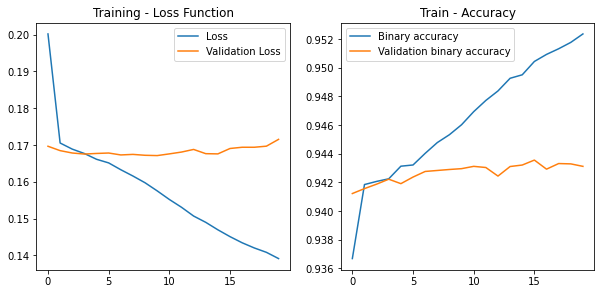

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history3.history['loss'], label='Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history3.history['binary_accuracy'], label='Binary accuracy')
plt.plot(history3.history['val_binary_accuracy'], label='Validation binary accuracy')
plt.legend()
plt.title('Train - Accuracy')

## Quatrième Modèle

In [ ]:
from keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import Lambda

# Couche d'entrée
input_layer = Input(shape=(2, 32, 32, 3))

# Supprimer l'axe 2 pour avoir un tensor 4D
reduce_dim = Lambda(lambda x: x[:, 0])(input_layer)

# Couches de convolution
conv_layer1 = Conv2D(32, (3,3), activation='relu', padding='same')(reduce_dim)
pool_layer1 = MaxPooling2D(pool_size=(2, 2))(conv_layer1)
conv_layer2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool_layer1)
pool_layer2 = MaxPooling2D(pool_size=(2, 2))(conv_layer2)
conv_layer3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool_layer2)
pool_layer3 = MaxPooling2D(pool_size=(2, 2))(conv_layer3)

# Couche de GlobalAveragePooling
gap_layer = GlobalAveragePooling2D()(pool_layer3)

#Couches de densité
dense_layer1 = Dense(512, activation='relu')(gap_layer)
dropout_layer = Dropout(0.5)(dense_layer1)
dense_layer2 = Dense(256, activation='relu')(dropout_layer)
dropout_layer2 = Dropout(0.5)(dense_layer2)
dense_layer3 = Dense(128, activation='relu')(dropout_layer2)

#Couche de sortie
output_layer = Dense(28, activation='sigmoid')(dense_layer3)


In [ ]:
# Initialisation du modèle
model4 = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2, 32, 32, 3)]    0         
                                                                 
 lambda_1 (Lambda)           (None, 32, 32, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                       

In [ ]:
from keras.optimizers import Adam
#Compilation du modèle
model4.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')

In [ ]:
#Entraînement du modèle
history4 = model4.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val),
                      callbacks=[early_stopping])

Epoch 1/100
389/389 [==============================] - 56s 142ms/step - loss: 0.1909 - binary_accuracy: 0.9374 - val_loss: 0.1746 - val_binary_accuracy: 0.9415
Epoch 2/100
389/389 [==============================] - 56s 145ms/step - loss: 0.1715 - binary_accuracy: 0.9415 - val_loss: 0.1661 - val_binary_accuracy: 0.9416
Epoch 3/100
389/389 [==============================] - 55s 141ms/step - loss: 0.1620 - binary_accuracy: 0.9463 - val_loss: 0.1559 - val_binary_accuracy: 0.9482
Epoch 4/100
389/389 [==============================] - 54s 139ms/step - loss: 0.1574 - binary_accuracy: 0.9481 - val_loss: 0.1546 - val_binary_accuracy: 0.9486
Epoch 5/100
389/389 [==============================] - 55s 143ms/step - loss: 0.1554 - binary_accuracy: 0.9486 - val_loss: 0.1522 - val_binary_accuracy: 0.9494
Epoch 6/100
389/389 [==============================] - 54s 139ms/step - loss: 0.1531 - binary_accuracy: 0.9492 - val_loss: 0.1515 - val_binary_accuracy: 0.9495
Epoch 7/100
389/389 [===================

In [ ]:
#Evaluation du modèle
test_loss, test_acc = model4.evaluate(X_test, y_test)
print('Test accuracy : ', test_acc)

98/98 [==============================] - 2s 21ms/step - loss: 0.1363 - binary_accuracy: 0.9540
Test accuracy :  0.9540470242500305


#### Plot de Training Accuracy vs Loss pour mieux comprendre le modèle d'entraînement.

Text(0.5, 1.0, 'Train - Accuracy')

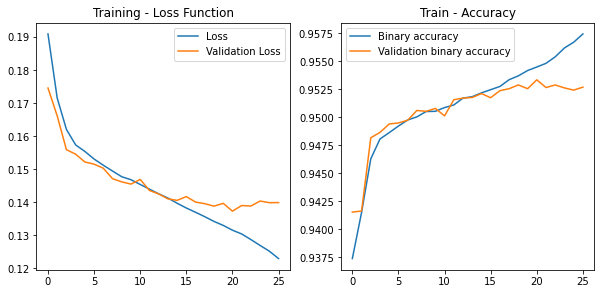

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history4.history['loss'], label='Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history4.history['binary_accuracy'], label='Binary accuracy')
plt.plot(history4.history['val_binary_accuracy'], label='Validation binary accuracy')
plt.legend()
plt.title('Train - Accuracy')

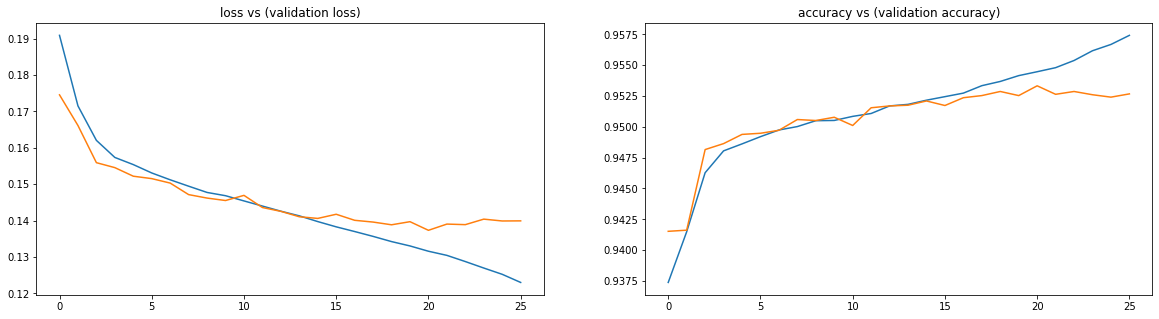

In [ ]:
figures = ['loss', "binary_accuracy"]
titles = ["loss vs (validation loss)", "accuracy vs (validation accuracy)"] 
plt.figure(figsize = (20, 5))
for i in range(2):
  plt.subplot(1, 2, (i + 1))
  plt.title(titles[i])
  plt.plot(history4.history[figures[i]])
  plt.plot(history4.history['val_{}'.format(figures[i])])
plt.show()
     

In [ ]:
import tensorflow as tf
#Entraînement du modèle
history5 = model4.fit(img_np_array,target_sample, epochs=100, batch_size=64, validation_split = 0.1,
                      callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode = 'min',
                                  patience= 1),
              tf.keras.callbacks.EarlyStopping(patience = 7, monitor = 'val_loss', mode = 'min', restore_best_weights=True)])

In [ ]:
figures = ['loss', "binary_accuracy"]
titles = ["loss vs (validation loss)", "accuracy vs (validation accuracy)"] 
plt.figure(figsize = (20, 5))
for i in range(2):
  plt.subplot(1, 2, (i + 1))
  plt.title(titles[i])
  plt.plot(history5.history[figures[i]])
  plt.plot(history5.history['val_{}'.format(figures[i])])
plt.show()
     